In [1]:
#from pygraph.classes.graph import graph
#from pygraph.readwrite import dot
#from pygraph.algorithms.minmax import shortest_path
#from pygraph.algorithms.accessibility import connected_components
#from pygraph.algorithms.pagerank import pagerank

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
import itertools
import random
import statistics

In [4]:
from scipy.stats import power_divergence

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from network import *

In [7]:
import math

In [8]:
from loaders import *

In [9]:
from IPython.core.display import Image, display

In [10]:
def construct_graph_filtered(old_graph, node_predicate, egde_predicate):
    new_graph = nx.Graph()
    for node in old_graph.nodes():
        if node_predicate(node):
            new_graph.add_node(node)
    for edge in old_graph.edges():
        if node_predicate(edge[0]) and node_predicate(edge[1]) and egde_predicate(edge):
            new_graph.add_edge(edge)
    return new_graph

In [11]:
# calculate distance distribution for 
# detect small world phenomenon
def get_distance_stat(graph, n):
    stat = {}
    summ = len(graph.nodes()) * n
    for i in range(n): # iterative calculation of shortest path
        random_author = random.choice(graph.nodes())
        distances = nx.shortest_path_length(graph, random_author)
        for x in distances.values():
            stat[x] = stat.get(x, 0) + 1;
    return dict( (key, value / summ) for key, value in stat.items() )
        

In [12]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [13]:
import networkx as nx
#calculate centrality statistics
def get_centrality_stat(graph):
    N = len(graph.nodes())
    centrality_stat = nx.degree_centrality(graph)
    print("----------")
    print("Average degree node centrality:", sum(centrality_stat.values())/len(centrality_stat) )
    
    max_centrality = max(centrality_stat.values())
    print("Maxumum degree node centrality:", max_centrality)
    
    nodes_num = len(graph.nodes())
    print("Degree graph centrality:", 
          sum([max_centrality - x for x in centrality_stat.values()])/((nodes_num - 1)*(nodes_num - 2)))
    
    print("----------")
    return [math.log(value + 1) if value > 0 else 0 for i, value in centrality_stat.items()]
        

In [14]:
def calc_pagerank(graph):
    TOP = 50
    percent_threshold = 0.1
    weighted_nodes = nx.pagerank(graph)
    sorted_nodes = sorted(weighted_nodes.items(), key = lambda pair: pair[1], reverse=True)
    node_ranks = dict( (val, idx) for idx, val in enumerate(sorted_nodes))
#     print(sorted_nodes[0:TOP])
    top_subgraph = graph.subgraph([x[0] for x in sorted_nodes[0:TOP]])
    return (top_subgraph, weighted_nodes, sorted_nodes)
    

In [15]:
def plot_dict(stat, xlbl, ylbl):
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [16]:
def plot_list(stat, xlbl, ylbl):
    plt.plot(stat)
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [17]:
def plot_weighet_graph(graph, weights=None):
    if weights == None:
        weights = [1] * len(graph.nodes())
    
    nodesize = [weights[v] * 10000 for v in graph]
    try:
        pos=nx.nx_agraph.graphviz_layout(graph)
    except:
        pos=nx.spring_layout(graph,iterations=20)
    nx.draw(graph, node_size=nodesize, pos=pos, node_color="w")
    nx.draw_networkx_labels(graph, pos)
    

In [18]:
def get_time_seriece(weights_per_period, node):
    return [weights.get(node, 0.0) for weights in weights_per_period]

In [19]:
def get_weights_in_period(file ,start, end):
    coauthorNetwork = load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    (auth_subgraph, auth_weights, auth_sorted_nodes) = calc_pagerank(coauthorNetwork.gr)
    (cite_subgraph, cite_weights, cite_sorted_nodes) = calc_pagerank(coauthorNetwork.cgr)
    print("Top researchers", cite_sorted_nodes[:10])
    return ((auth_weights, auth_sorted_nodes), (cite_weights, cite_sorted_nodes) )

In [20]:
import operator

def analize_component(coauthorNetwork, components, component_num):
    print("----------")
    print("Component:", component_num + 1)
    PRECISION = 50 # number of authors to calc avg distance

    component_sizes = dict( (idx, len(c)) for idx, c in enumerate(components) )

    the_component = components[component_num]

    component_subgraph = coauthorNetwork.gr.subgraph(the_component)
    
    print("Authors count:",len(component_subgraph.nodes()))
    stat = get_distance_stat(component_subgraph, PRECISION)
    
    print("Mean distance:", sum([value * key for key, value in stat.items()]))
    print(" ")
    print("Distance distribution")
    plot_dict(stat, "rank", "density")
    
    cstat = get_centrality_stat(coauthorNetwork.cgr)
    sorted_cstat = sorted(cstat, reverse=True)
    plot_list(sorted_cstat, "rank", "log node centrality")
#     print("Degree Nodes Centrality (first N elements):", cstat)
    #print(stat)



In [21]:
def load_with_loader(file, loader, article_filter = None):
    coauthorNetwork = CoauthorNetwork()
    if article_filter == None:
        article_filter = lambda x: True
    for article in loader(file):
        if article_filter(article):
            coauthorNetwork.add_article(article)
    coauthorNetwork.create_cite_graph()

    print("Uniq authors:", len([x for x in coauthorNetwork.author_to_article.keys()]))
    return coauthorNetwork
    
#file = "./data/authors/Medical Informatics.txt"
#file = "./data/out_test.txt"
#coauthorNetwork = analyse(file, parse_dataset_file)
#components = connected_components(coauthorNetwork.gr)


#!dot 'graph.dot' -Tpng -o "graph.png"
#display(Image('graph.png' ))

In [22]:
def run_analyse(file, article_filter = None):
    print("Dataset:", file)
    coauthorNetwork = load_with_loader(file, parse_dataset_file, article_filter)
    
    components = [c for c in sorted(nx.connected_components(coauthorNetwork.gr), key=len, reverse=True)]
    
    components_sizes = dict((idx, math.log(float(len(c)))) for idx, c in enumerate(components))
    print(" ")
    print("Connected component distribution (log-scale)")
    plot_dict(components_sizes, "rank", "size(log)")
    
    print(power_divergence([len(c) for c in components]))
    
    #components = connected_components(coauthorNetwork.gr)
    component_count = len(components)
    print("Connected component count:", component_count)
    
    analize_component(coauthorNetwork, components, 0)

Dataset: ./data/out_test.txt
Uniq authors: 184962
 
Connected component distribution (log-scale)


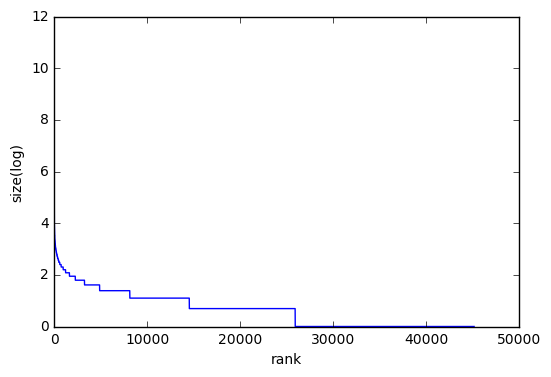

Power_divergenceResult(statistic=1246421768.3911831, pvalue=0.0)
Connected component count: 45147
----------
Component: 1
Authors count: 71460
Mean distance: 9.3603744752309
 
Distance distribution


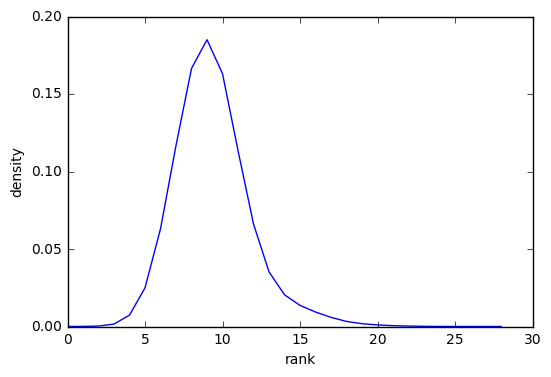

----------
Average degree node centrality: 4.120809198537614e-06
Maxumum degree node centrality: 0.000681224690610453
Degree graph centrality: 3.6608322999793647e-09
----------


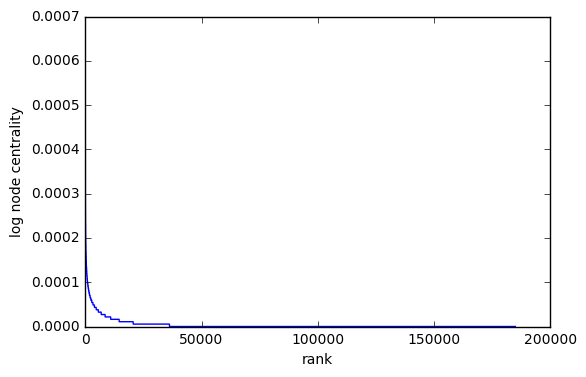

In [23]:
run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")


In [24]:
# Analyse time series

file = "./data/out_test.txt"

coauthorNetwork = load_with_loader(file, parse_dataset_file)
nodes_count = len(coauthorNetwork.gr.nodes())

train_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]
test_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]

weights_per_period = []
weights_per_period.append(get_weights_in_period(file, 1990, 1995))
weights_per_period.append(get_weights_in_period(file, 1995, 2000))
weights_per_period.append(get_weights_in_period(file, 2000, 2005))
weights_per_period.append(get_weights_in_period(file, 2005, 2010))

weights_per_period_auth = [ w[0][0] for w in weights_per_period ]
weights_per_period_cite = [ w[1][0] for w in weights_per_period ]

x_train = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

# print("x_train", x_train[0:10])
# print("y_train", y_train[0:10])
x_test = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_test = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)

for pair in zip(lm.predict(x_test)[0:10], y_test[0:10]):
    print(pair)
    
# print(lm.predict(x_test)[0:10])
# print(y_test[0:10])


Uniq authors: 184962
Uniq authors: 5397
Top researchers [('Nancy Chinchor', 0.0012563105852751637), ('Beth M. Sundheim', 0.0006528797040603286), ('Joel J. Luna', 0.0005829514778125361), ('T. Y. Lin', 0.0005829514778125361), ('Terry Rooker', 0.0005829514778125361), ('Jerry R. Hobbs', 0.0004993673115835725), ('Steve Whittaker', 0.00043155911777536333), ('Robert Allen', 0.0004315591177753633), ("Brid O'Conaill", 0.0004315591177753633), ('David Garlan', 0.0004315591177753633)]
Uniq authors: 45509
Top researchers [('Donald E. Knuth', 0.00045727065569892893), ('Bertrand Meyer', 0.00029570920631529044), ('Teuvo Kohonen', 0.00018885763116898235), ('Hiroshi Ishii', 0.00010595343848705338), ('Brygg Ullmer', 0.00010595343848705338), ('Saul Greenberg', 0.00010193694072755973), ('George W. Furnas', 8.683110894260953e-05), ('John Barkley', 8.29257875176766e-05), ('Ravi Sandhu', 8.199190630736655e-05), ('Mark Crovella', 8.05158266654296e-05)]
Uniq authors: 26413
Top researchers [('Shumin Zhai', 0.000